# B-tree Implementation for Key-value Store
#### An example project illustring B-tree implementation in a key-value store, with numeric or non-numeric unique keys, range look-up, and functional and performance tests

In [1]:
# To structure code automatically
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import B-Tree Implementation

In [2]:
from btree import BTree

<IPython.core.display.Javascript object>

### KVStore Implementation

In [3]:
class KVStore(BTree):
    def __init__(self, split_threshold=2):
        super().__init__(split_threshold)

    def __getitem__(self, key):
        return self.get_value(key)

    def __setitem__(self, key, value):
        self.add(key, value)

    def __contains__(self, key):
        return self.contains(key)

    def _range_query(
        self, current_node, range_start, range_end, min_key, max_key,
    ):
        if range_end < min_key or range_start > max_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(
                    child, range_start, range_end, new_min_key, new_max_key
                )
        return results

    def range_query(self, range_start, range_end):
        key_numeric = str(range_start).isnumeric()
        if key_numeric:
            min_key = float("-inf")
            max_key = float("inf")
        else:
            str_factor = len(range_end) + 5
            min_key = ""
            max_key = "z" * str_factor

        return self._range_query(self.root, range_start, range_end, min_key, max_key,)

<IPython.core.display.Javascript object>

### Testing KVStore with Numeric Keys

In [4]:
# Test for split_threshold
print("Testing Split Threshold")
kv = KVStore()
assert kv.split_threshold == 2, "The split threshold is not equal to 2."

# Test for initial key, value add
print("Testing Initial Add")
keys = list(range(0, 10))

for i in keys:
    kv.add(i, i)
for i in keys:
    assert kv.get_value(i) == i, "Expected value not retrieved."

# Test for updated value add
print("Testing Value Overwrite")
for i in keys:
    kv.add(i, i + 1)

for i in keys:
    assert kv.get_value(i) == i + 1, "Expected value not retrieved."

# Test for bracket syntax assignment
print("Testing Assignment with Bracket Syntax")
for i in keys:
    kv[i] = i
for i in keys:
    assert kv.get_value(i) == i, "Expected value not retrieved."

# Test for bracket syntax retrieval
print("Testing Retrieval with Bracket Syntax")
for i in keys:
    kv[i] == i, "Expected value not retrieved."

# Test for value overwrite with bracket syntax
print("Testing Value Overwrite with Bracket Syntax")
for i in keys:
    kv[i] = i + 1
for i in keys:
    assert kv.get_value(i) == i + 1, "Expected value not retrieved."

# Re-test bracket syntax retrieval with updated values
print("Testing Retrieval with Bracket Syntax after Value Overwrite")
for i in keys:
    assert kv[i] == i + 1, "Expected value not retrieved."

# Testing bracket syntax for contains key
print("Testing the In Operator")
for i in keys:
    assert kv.contains(i), "Expected value not retrieved."
not_keys = [i - 100 for i in keys]
for not_i in not_keys:
    assert not kv.contains(not_i), "Expected value not retrieved."

# Testing range_query
print("Testing Range Query")
sub_keys = keys[2:9]
for i in keys:
    kv[i] = i
for i in sub_keys:
    assert i in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."
for i in [i for i in keys if i not in sub_keys]:
    assert i not in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."

Testing Split Threshold
Testing Initial Add
Testing Value Overwrite
Testing Assignment with Bracket Syntax
Testing Retrieval with Bracket Syntax
Testing Value Overwrite with Bracket Syntax
Testing Retrieval with Bracket Syntax after Value Overwrite
Testing the In Operator
Testing Range Query


<IPython.core.display.Javascript object>

### Testing KVStore with String Keys

In [5]:
kv = KVStore()
keys = "abcdefghijk"
for i in keys:
    kv[i] = i

# Testing bracket syntax for contains key
print("Testing the In Operator")
for i in keys:
    assert kv.contains(i), "Expected value not retrieved"
not_keys = ["lmnopqrstuvwxyz"]
for not_i in not_keys:
    assert not kv.contains(not_i), "Expected value not retrieved"

# Testing range_query
print("Testing Range Query")
sub_keys = keys[2:9]
for i in keys:
    kv[i] = i
for i in sub_keys:
    assert i in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."
for i in [i for i in keys if i not in sub_keys]:
    assert i not in kv.range_query(keys[2], keys[8]), "Expected value not retrieved."

Testing the In Operator
Testing Range Query


<IPython.core.display.Javascript object>

### Comparing Results for KVStore Extending Built-in Dictionary Class and New KVStore

#### Defining `range_query` Method for Built-in Dictionary Class

In [6]:
class DictKVStore(dict):
    def range_query(self, range_start, range_end):
        results = []
        for key in self.keys():
            if range_start <= key <= range_end:
                results.append(self[key])
        return results

<IPython.core.display.Javascript object>

#### Comparing `range_query` for Both KVStores

In [7]:
# For numeric keys
print("Testing for Matching Results for Numeric Keys")
dict_kv = DictKVStore()
new_kv = KVStore()

for i in range(10):
    dict_kv[i] = i
    new_kv[i] = i

ranges = [(0, 5), (1, 5), (6, 7), (9, 9), (3, 8)]

for range_start, range_end in ranges:
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, "Results do not match for the different KVStores"

# For string keys
print("Testing for Matching Results for String Keys")
dict_kv = DictKVStore()
new_kv = KVStore()

for i in "efghijklmnopq":
    dict_kv[i] = i
    new_kv[i] = i

ranges = [("a", "z"), ("c", "l"), ("m", "m"), ("e", "q"), ("w", "z")]

for range_start, range_end in ranges:
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, "Results do not match for the different KVStores"

Testing for Matching Results for Numeric Keys
Testing for Matching Results for String Keys


<IPython.core.display.Javascript object>

### Random Tests

#### Random Tests for Numeric Keys

In [8]:
import random

random.seed(42)

num_inserts = 10
num_range_queries = 10
num_contains = 10

dict_kv = DictKVStore()
new_kv = KVStore()

print("Testing Insertion")
for _ in range(num_inserts):
    key = random.randint(0, 100)
    value = random.randint(0, 1000000)
    dict_kv[key] = value
    new_kv[key] = value

print("Testing Length")
assert len(dict_kv) == len(
    new_kv
), f"The legths do not match: {len(dict_kv)} and {len(new_kv)}."

print("Testing Values")
for key in dict_kv:
    assert (
        dict_kv[key] == new_kv[key]
    ), f"Wrong value for key {key}.  Expected {dict_kv[key]} but found {new_kv[key]}."

print("Testing in Operator")
for _ in range(num_contains):
    key = random.randint(0, 100)
    assert (key in dict_kv) == (key in new_kv)

print("Testing Range Query")
for _ in range(num_range_queries):
    range_start = random.randint(0, 100)
    range_end = random.randint(range_start, 100)
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, f"The results for key {key} do not match."

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Query


<IPython.core.display.Javascript object>

#### Random Tests for String Keys

In [9]:
letters = sorted(
    [char for char in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"]
)

num_inserts = 10
num_range_queries = 10
num_contains = 10

dict_kv = DictKVStore()
new_kv = KVStore()

print("Testing Insertion")
for _ in range(num_inserts):
    key = letters[random.randint(0, len(letters))]
    value = letters[random.randint(0, len(letters))]
    dict_kv[key] = value
    new_kv[key] = value

print("Testing Length")
assert len(dict_kv) == len(
    new_kv
), f"The legths do not match: {len(dict_kv)} and {len(new_kv)}."

print("Testing Values")
for key in dict_kv:
    assert (
        dict_kv[key] == new_kv[key]
    ), f"Wrong value for key {key}.  Expected {dict_kv[key]} but found {new_kv[key]}."

print("Testing in Operator")
for _ in range(num_contains):
    key = letters[random.randint(0, len(letters))]
    assert (key in dict_kv) == (key in new_kv)

print("Testing Range Query")
for _ in range(num_range_queries):
    range_start_index = random.randint(0, len(letters))
    range_start = letters[range_start_index]
    range_end_index = random.randint(range_start_index, len(letters))
    range_end = letters[range_end_index]
    dict_kv_res = sorted(dict_kv.range_query(range_start, range_end))
    new_kv_res = sorted(new_kv.range_query(range_start, range_end))
    assert dict_kv_res == new_kv_res, f"The results for key {key} do not match."

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Query


<IPython.core.display.Javascript object>

### Performance Testing

In [10]:
import time
import csv

# Creating a csv file of the entries
with open("entries.csv", "w", newline="") as f:
    writer = csv.writer(f)
    header = ["key", "value"]
    writer.writerow(header)
    for i in range(0, 50000):
        key = random.randint(0, 100000)
        value = random.randint(0, 100000)
        row = [key, value]
        writer.writerow(row)

# Creating a csv file of the query ranges
with open("queries.csv", "w", newline="") as f:
    writer = csv.writer(f)
    header = ["range_start", "range_end"]
    writer.writerow(header)
    for i in range(1, 1001):
        increment = i
        range_start = random.randint(0, 99000)
        range_end = range_start + i
        row = [range_start, range_end]
        writer.writerow(row)

<IPython.core.display.Javascript object>

In [11]:
# Creating kv stores
dict_kv = DictKVStore()
new_kv = KVStore()

with open("entries.csv") as f:
    reader = csv.reader(f)
    rows = list(reader)
    for row in rows[1:]:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        new_kv[key] = value

# Comparing Performance on range queries
dict_kv_times = []
new_kv_times = []

with open("queries.csv") as f:
    reader = csv.reader(f)
    rows = list(reader)
    for row in rows[1:]:
        range_start = int(row[0])
        range_end = int(row[1])

        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        dict_kv_times.append(end - start)

        start = time.time()
        new_kv.range_query(range_start, range_end)
        end = time.time()
        new_kv_times.append(end - start)

<IPython.core.display.Javascript object>

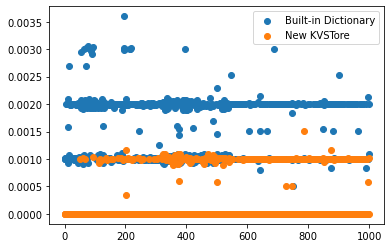

<IPython.core.display.Javascript object>

In [16]:
import matplotlib.pyplot as plt

plt.scatter(range(len(dict_kv_times)), dict_kv_times, label="Built-in Dictionary")
plt.scatter(range(len(new_kv_times)), new_kv_times, label="New KVSTore")
plt.legend()

In [26]:
times_dict = {}
for i, time in enumerate(dict_kv_times):
    times_dict[i] = time - new_kv_times[i]

<IPython.core.display.Javascript object>

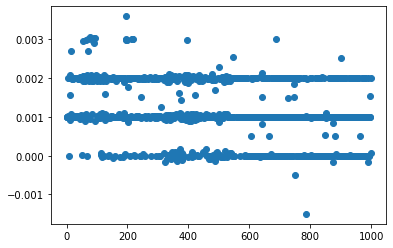

<IPython.core.display.Javascript object>

In [27]:
plt.scatter(times_dict.keys(), times_dict.values())

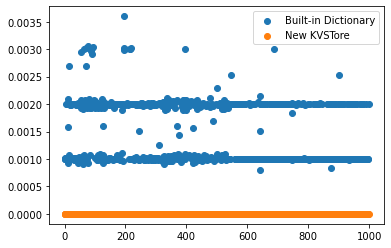

<IPython.core.display.Javascript object>

In [36]:
times_dict = {}
times_dict2 = {}
for i, time in enumerate(dict_kv_times):
    if time > 0 and new_kv_times[i] == 0:
        times_dict[i] = time
        times_dict2[i] = new_kv_times[i]

plt.scatter(times_dict.keys(), times_dict.values(), label="Built-in Dictionary")
plt.scatter(times_dict2.keys(), times_dict2.values(), label="New KVSTore")
plt.legend()